# SEM for schadenfreude manuscript

In [ ]:
library(tidyverse)
library(lavaan)
library(lubridate)
library(semPlot)

# Choose paths for input data and output data
ready_path <- '../data_tmp/'
out_path <- '../out_tmp/'

In [8]:
# Read in the production data
# This comes from package knb-lter-jrn.210349001 on EDI
df <- read_csv(paste0(ready_path, 'jrn349001_cover_and_biomass_juntar.csv'),
               col_types = list(ppt_trt = col_character())) %>%
    mutate(PPT_treatment = case_match(ppt_trt,
                                      '0.2' ~ '-80%', 
                                      '1.0' ~ 'ambient',
                                      '1.8' ~ '+80%'))
str(df)

tibble [827 × 13] (S3: tbl_df/tbl/data.frame)
 $ year         : num [1:827] 2006 2006 2006 2006 2006 ...
 $ plotid       : num [1:827] 104 108 114 126 134 136 137 140 203 206 ...
 $ ppt_trt      : chr [1:827] "0.2" "0.2" "0.2" "0.2" ...
 $ n_trt        : num [1:827] 1 0 1 0 0 1 1 0 1 0 ...
 $ cover_grass  : num [1:827] 0.479 0.395 0.33 0.461 0.459 ...
 $ cover_shrub  : num [1:827] 0.1067 0.127 0.0927 0.2803 0.0369 ...
 $ cover_rare   : num [1:827] 0.0183 0.1173 0.1304 0.1976 0.1018 ...
 $ cover_total  : num [1:827] 0.604 0.64 0.554 0.939 0.597 ...
 $ biomass_grass: num [1:827] 126.8 104.6 87.4 122.1 121.3 ...
 $ biomass_shrub: num [1:827] 19.7 23.4 17.1 51.7 6.8 ...
 $ biomass_rare : num [1:827] 3.38 21.65 24.08 36.48 18.79 ...
 $ biomass_total: num [1:827] 150 150 129 210 147 ...
 $ PPT_treatment: chr [1:827] "-80%" "-80%" "-80%" "-80%" ...


In [9]:
# Load precipitation data
# This comes from package knb-lter-jrn.210349002 on EDI
ppt <- read_csv(paste0(ready_path, 'seasonal_ppt_juntar.csv'),
                col_types = list(ppt_trt = col_character())) %>%
    mutate(PPT_treatment = case_match(ppt_trt,
                                      '0.2' ~ '-80%', 
                                      '1.0' ~ 'ambient',
                                      '1.8' ~ '+80%'))
# Split the seasons
gs_ppt <- subset(ppt, season=='growing_season')
ann_ppt <- subset(ppt, season=='annual')
# Rename columns so they can be merged
gs_ppt <- gs_ppt %>% rename("gs_ppt_mm" = "ppt_mm")
ann_ppt <- ann_ppt %>% rename("ann_ppt_mm" = "ppt_mm")
str(gs_ppt)

tibble [57 × 5] (S3: tbl_df/tbl/data.frame)
 $ year         : num [1:57] 2006 2007 2008 2009 2010 ...
 $ ppt_trt      : chr [1:57] "0.2" "0.2" "0.2" "0.2" ...
 $ gs_ppt_mm    : num [1:57] 36.2 29.6 56.7 19.5 28 ...
 $ season       : chr [1:57] "growing_season" "growing_season" "growing_season" "growing_season" ...
 $ PPT_treatment: chr [1:57] "-80%" "-80%" "-80%" "-80%" ...


In [10]:
# Merge precip data with plot data and calculate shrub ratio and RUE
df <- merge(df, ann_ppt[,c('year','PPT_treatment','ann_ppt_mm')], on=c('year', 'PPT_treatment'), all.x=T)
df <- merge(df, gs_ppt[,c('year','PPT_treatment','gs_ppt_mm')], on=c('year', 'PPT_treatment'), all.x=T)
str(df)

'data.frame':	827 obs. of  15 variables:
 $ year         : num  2006 2006 2006 2006 2006 ...
 $ PPT_treatment: chr  "-80%" "-80%" "-80%" "-80%" ...
 $ plotid       : num  104 108 114 126 134 136 137 140 203 206 ...
 $ ppt_trt      : chr  "0.2" "0.2" "0.2" "0.2" ...
 $ n_trt        : num  1 0 1 0 0 1 1 0 1 0 ...
 $ cover_grass  : num  0.479 0.395 0.33 0.461 0.459 ...
 $ cover_shrub  : num  0.1067 0.127 0.0927 0.2803 0.0369 ...
 $ cover_rare   : num  0.0183 0.1173 0.1304 0.1976 0.1018 ...
 $ cover_total  : num  0.604 0.64 0.554 0.939 0.597 ...
 $ biomass_grass: num  126.8 104.6 87.4 122.1 121.3 ...
 $ biomass_shrub: num  19.7 23.4 17.1 51.7 6.8 ...
 $ biomass_rare : num  3.38 21.65 24.08 36.48 18.79 ...
 $ biomass_total: num  150 150 129 210 147 ...
 $ ann_ppt_mm   : num  77.2 77.2 77.2 77.2 77.2 ...
 $ gs_ppt_mm    : num  36.2 36.2 36.2 36.2 36.2 ...


## Mediation 2, growing season ppt

In [13]:
med.model.2gs <- "
  biomass_grass ~ gs_ppt_mm  
  biomass_shrub ~ gs_ppt_mm + biomass_grass
"
med.2gs.fit <- sem(med.model.2gs, data=df)

In [14]:
summary(med.2gs.fit, rsq=TRUE, standardized=F, fit.measures=F)

lhs,op,rhs,exo,est,se,z,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
biomass_grass,~,gs_ppt_mm,0,2.339064e-01,0.01353532,17.2811879,0.0000000
biomass_shrub,~,gs_ppt_mm,0,-6.437146e-03,0.01073132,-0.5998468,0.5486083
biomass_shrub,~,biomass_grass,0,-4.711765e-01,0.02363115,-19.9387866,0.0000000
biomass_grass,~~,biomass_grass,0,2.348093e+03,115.47221560,20.3346994,0.0000000
biomass_shrub,~~,biomass_shrub,0,1.084402e+03,53.32768295,20.3346994,0.0000000
gs_ppt_mm,~~,gs_ppt_mm,1,1.549790e+04,0.00000000,NA,NA
biomass_grass,r2,biomass_grass,0,2.653065e-01,NA,NA,NA
biomass_shrub,r2,biomass_shrub,0,4.030506e-01,NA,NA,NA


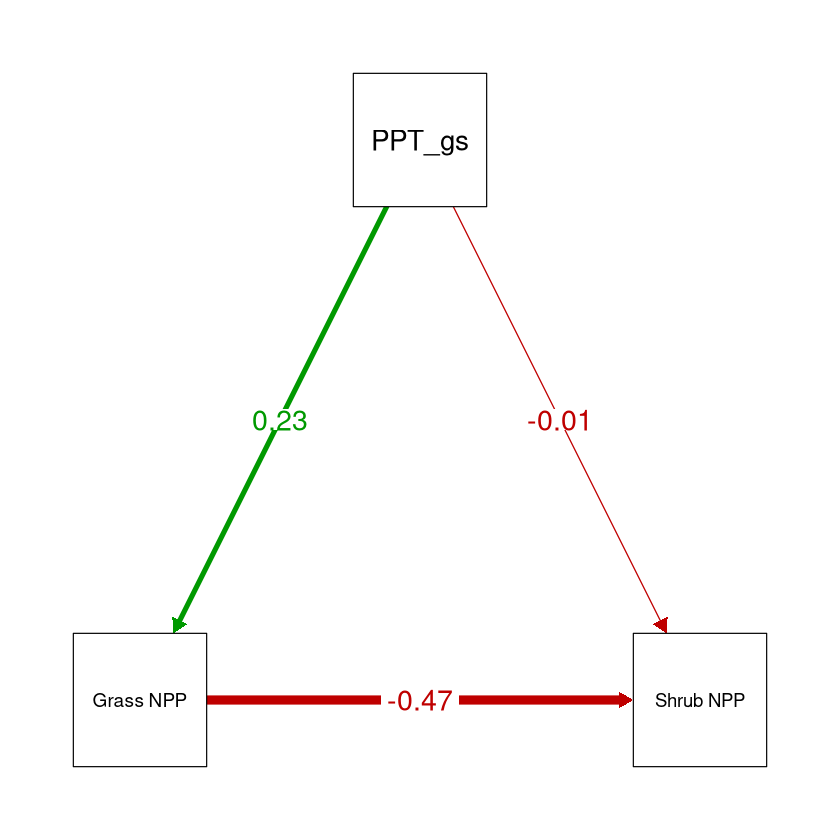

In [15]:
#png(paste0(out_path, 'fig2sem_med2_gs_2006-2024.png'), width=4, height=4, units='in', res=400)
#pdf(paste0(out_path, 'fig2sem_med2_gs_2006-2024.pdf'), width=4, height=4)
med2gs_plot <- semPlot::semPaths(med.2gs.fit, "par",
             sizeMan = 15, sizeInt = 15, sizeLat = 15,
             edge.label.cex=1.5,
             fade=FALSE, residuals=FALSE,
             nodeLabels=c('Grass NPP', 'Shrub NPP','PPT_gs'))
#dev.off()